In [9]:
%pylab inline
import scipy.stats
import scipy.constants as c
import scipy.signal
from scipy.special import erf, lambertw
import pandas as pd
import uncertainties as uc
import uncertainties.unumpy as unp
numpy.set_printoptions(linewidth=200)

if plt.get_backend() == 'Qt5Agg':
    def figure(name, *args, **kwargs):
        # fig = FIGS[name]
        fig = plt.figure(name, *args, **kwargs)
        fig.clf()
        fig.show()
        # plt.figure(fig.number)
        return fig
else:
    def figure(name, *args, **kwargs):
        plt.close(name)
        fig = plt.figure(name)
        return fig
    
EXPORT_FIGS=True
    
if EXPORT_FIGS:
    plt.rc('font', family='serif', size=12) 
    plt.rc('text', usetex='true')

plt.rcParams['figure.max_open_warning'] = 40
plt.rcParams['figure.figsize'] = 7.6, 4.6 # irrelevant for interactive plots
plt.rcParams["legend.columnspacing"] = 0.6
PLOT_COLORS = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
#'#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']
plt.rc('axes', prop_cycle=(cycler('color', PLOT_COLORS)))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figure']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
intens = pd.read_csv('Intens.csv', index_col=0, )
intens.columns = intens.columns.astype(float)
U_lmin = pd.read_csv('min_vs_U.csv', index_col=0)
U_lmin.columns = U_lmin.columns.astype(float)

In [11]:
Salz = pd.read_csv('XST.csv', usecols=[0, 1], index_col=0).dropna()['Salz']
Salz_zoom = pd.read_csv('XST.csv', usecols=[2, 3], index_col=0).dropna()['Salz_zoom']
Zr = pd.read_csv('XST.csv', usecols=[4, 5], index_col=0).dropna()['Zr']
Flip = pd.read_csv('XST.csv', usecols=[6, 7], index_col=0).dropna()['Flip']
LiF = pd.read_csv('XST.csv', usecols=[8, 9], index_col=0).dropna()['LiF']

<Figure size 547.2x331.2 with 0 Axes>

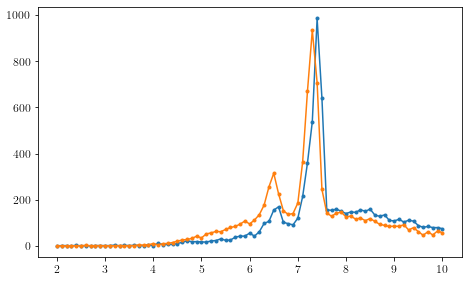

In [12]:
figure('overwiev')
plt.plot(Salz[:10], marker='.')
plt.plot(Flip.shift(0)/1.75, marker='.')
savetxt('Salz_flip.txt', transpose([Salz[:10].index, array(Salz[:10]), array(Flip)]),
        header='Winkel Salz Flip Flip_shift', comments='')

-> Ungenauigkeit ist $1.1^\circ$

In [13]:
ang_err = 0.1 * pi/180
a_NaCl = 564.02e-12

In [14]:
# Fit-Vorlagen
def double_gaussian_brems(x, x1, a1, s1, x2, a2, s2, lmin, K):
    cutoff = .5*erf((x-lmin)*100) + .5
    return K * (x / lmin - 1)/x**2 * cutoff\
               + a1*exp(-.5*(x - x1)**2/s1**2) \
               + a2*exp(-.5*(x - x2)**2/s2**2)

def N_gaussian(N, order2=True):
    def _gauss(x, *args):
        assert len(args) == 3*N + 2 + order2
        y = zeros_like(x, dtype=float64)
        for i in range(N):
            x0, a, s = args[3*i], args[3*i+1], args[3*i+2]
            y += a*exp(-.5*(x - x0)**2/s**2)
        y += args[-2-order2]*x + args[-1-order2]
        if order2:
            y += args[-1]*x**2
        return y
    _gauss.__name__=f'{N} gaussians'
    return _gauss
    
def gaussian0(x, x0, a, s):
    return a*exp(-.5*(x - x0)**2/s**2)
    
def gaussian(x, x0, a, s, m, t):
    return m*x + t + a*exp(-.5*(x - x0)**2/s**2)

def gaussian_nobkg(x, x0, a, s, m, t):
    return a*exp(-.5*(x - x0)**2/s**2)
    
def gaussian2(x, x0, a, s, m, t, q):
    return q*x**2 + m*x + t + a*exp(-.5*(x - x0)**2/s**2)

In [15]:
import inspect
def fit(x, y, start, end, curve=gaussian2, sigma=None):
    dx = mean(diff(x))
    if sigma is None:
        sigma = ones_like(y)
    
    peaks = scipy.signal.find_peaks_cwt(y[start:end], [4])
    n0 = max(peaks, key=y[start:].__getitem__) + start
    
    nparams = len(inspect.signature(curve).parameters) - 1
    p0 = [x[n0], y[n0], 5*dx] + [0]*(nparams - 3)
    #bounds = ([-inf]*5 + [0] if curve is gaussian2 else [-inf]*nparams, [inf]*nparams)
    
    popt, _ = scipy.optimize.curve_fit(curve, x[start:end], y[start:end],
                                       p0=p0, sigma=sigma[start:end], maxfev=10000)
    return popt

DEFAULT_CURVE=gaussian
def show_fits(x, y, endpt, stdev=None, name=None, convert=False, curve=DEFAULT_CURVE, s=False):
    """convert bezieht sich auf, endpts und graphen, nicht auf Output"""
    if name is None:
        figure(f'peak fits (#{hash((sum(y-y**2), sum(endpt)))%10**8})')
    else:
        figure(name)
        
    y = array(y, copy=True)
    
    mus = []
    sigma = []
    params = []
    for start, end in endpt:
        if isinstance(curve, dict):
            crv = curve.get((start, end), DEFAULT_CURVE)
        else:
            crv = curve
            
        n0, n1 = searchsorted(x, [start, end]) + [0, 1]
        popt = fit(x, y, n0, n1, curve=crv, sigma=stdev)
        try:
            crv_nobkg = eval(crv.__name__ + '_nobkg')
            y[n0:n1] -= crv_nobkg(x[n0:n1], *popt)
        except NameError:
            print('no signal substraction')
        
        mus.append(popt[0])
        sigma.append(abs(popt[2]))
        params.append(popt)
        X = linspace(x[n0], x[n1-1], 100)
        plt.plot(X, crv(X, *popt))
        
    #plt.legend([*[f'{"E" if convert else "x"}_0 = {cnv(x0):.5}' for x0 in x], 'data'])
    return array(mus), array(sigma), array(params)

def interval(x, x0, x1):
    return searchsorted(x, [x0, x1]) + [0, 1]

angle $\phi$  with error $\delta \phi$
--> Wavelength $\lambda = a \sin\phi$ with error $\delta \lambda = a \cos \phi \cdot \delta\phi= \sqrt{a^2 - \lambda^2} \delta\phi$

64.1+/-1.2
72.5+/-1.0
127.1+/-1.1
143.1+/-1.0
190.5+/-1.0
213.9+/-1.1


(17, 242)

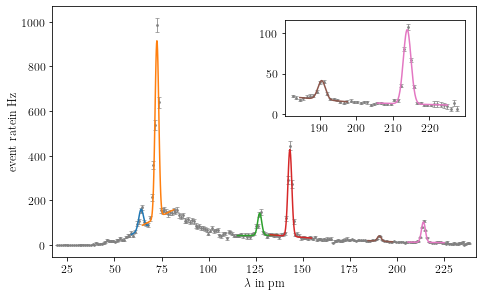

In [16]:
x = sin(Salz.index * pi/180)*a_NaCl*1e12

wt = array(1 - 8/9 * ((18.0 <= Salz.index) & (Salz.index <= 23.0)))
y = array((wt* Salz) .add (8/9 * Salz_zoom, fill_value=0))

ranges = ([58, 67], [64, 81] , [115, 136], [132, 154], [184, 197], [205, 224])
mus, sigmas, params = show_fits(x, y, ranges, name='Salz-beugung', stdev=sqrt(y*wt))

fmt = dict(fmt='.', color='gray', zorder=-1, capsize=2, elinewidth=.75, markeredgewidth=.65, markersize=4)

_ = plt.errorbar(x, y, yerr=sqrt(y*wt), **fmt)
                

# x2 = sin(Flip.index * pi/180) * a_NaCl * 1e12
# y2 = array(Flip)
# plt.scatter(x2, y2, marker='.', color='black', label='flipped')
# 
# n0, n1 = interval(x, 56, 80)
# 
# f = N_gaussian(2, order2=True)
# popt, pcov = scipy.optimize.curve_fit(f, x2[n0:n1], y2[n0:n1], p0=[62, 400, 2, 72, 900, 2, 100, 0, -1])
# popt
# X = linspace(x[n0], x[n1-1], 150)
# plt.plot(X, f(X, *popt), color='magenta')
# peaks = array([popt[0], popt[3], *mus])
# widths = array([popt[2], popt[5], *sigmas])

peaks = mus
widths = sigmas

print(*unp.uarray(peaks, widths), sep='\n')
errs = sqrt((a_NaCl*1e12)**2 - peaks**2) * ang_err

_ = plt.xlabel('$\lambda$ in pm')
_ = plt.ylabel('event ratein Hz')

# plt.legend()
plt.xlim([17, 242])

a = plt.axes([.55, .55, .33, .29])
n0, n1 = interval(x, 182, 227)
_ = a.errorbar(x[n0:n1], y[n0:n1], yerr=sqrt((y*wt)[n0:n1]), **fmt)
               
n0, n1 = interval(x, *ranges[4])
X = linspace(x[n0], x[n1-1], 150)
_ = a.plot(X, gaussian(X, *params[4]), color=PLOT_COLORS[4])
n0, n1 = interval(x, *ranges[5])
X = linspace(x[n0], x[n1-1], 150)
_ = a.plot(X, gaussian(X, *params[5]), color=PLOT_COLORS[5])

if EXPORT_FIGS:
    plt.savefig('Salz_peaks.pgf', bbox_inches='tight', transparent="True", pad_inches=0)


In [17]:
def direct_linear(x, a):
    return a*x

<Figure size 547.2x331.2 with 0 Axes>

<ErrorbarContainer object of 3 artists>

71.5+/-1.0
63.6+/-1.0


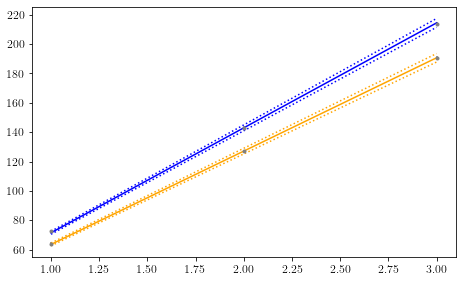

In [18]:
figure('Salz-peaks')
# plt.errorbar([1, 1], peaks[:2], yerr=widths[:2], fmt='.', color='magenta')
plt.errorbar([1, 1, 2, 2, 3, 3], peaks, yerr=widths, fmt='.', color='gray')

(p,), ((err,),) = scipy.optimize.curve_fit(direct_linear, [1, 2, 3], peaks[0::2], sigma=widths[0::2])
Kb = uc.ufloat(p, err + mean(errs[::2]))
(p,), ((err,),) = scipy.optimize.curve_fit(direct_linear, [1, 2, 3], peaks[1::2], sigma=widths[1::2])
Ka = uc.ufloat(p, err + mean(errs[1::2]))

X = array([1, 3])
plt.plot(X, Ka.n * X, color='blue')
plt.plot(X, (Ka.n - Ka.s) * X, ':', color='blue')
plt.plot(X, (Ka.n + Ka.s) * X, ':', color='blue')
plt.plot(X, Kb.n * X, color='orange')
plt.plot(X, (Kb.n - Kb.s) * X, ':', color='orange')
plt.plot(X, (Kb.n + Kb.s) * X, ':', color='orange')

savetxt('Mo_lines.txt', transpose([[1, 1, 2, 2, 3, 3, ], peaks]), header='n lambda', comments='')
savetxt('Mo_params.txt', [Ka.n, Ka.s, Kb.n, Kb.s])

/print Ka Kb sep='\n'

In [19]:
Mo_K, Mo_L3, Mo_M3 = c.eV * array([19999.4, 2520.2, 392.3])
Mo_Ka = Mo_K - Mo_L3
Mo_Kb = Mo_K - Mo_M3
c.h * c.c / Mo_Ka * 1e12
c.h * c.c / Mo_Kb * 1e12

70.93242104696277

63.23433725354956

<ErrorbarContainer object of 3 artists>

Text(0.5, 1, 'Absorbtion')

(0, 1)

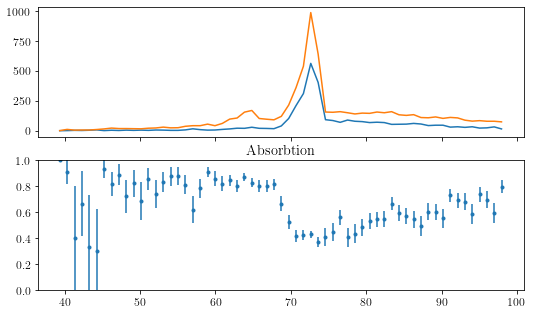

In [20]:
fig = figure('Zr Transmission')
axs = fig.subplots(nrows=2, sharex=True,)
plt.tight_layout()

x = sin(Zr.index * pi/180) * a_NaCl*1e12

axs[0].plot(x, Zr)
axs[0].plot(x, Salz[4:10])

y = array(1 - Zr/Salz[4:10])

ratio_err = sqrt(Zr)/Salz[4:10] * sqrt(1 + (1 - y)**2)
axs[1].errorbar(x, y, yerr=ratio_err, fmt='.')
axs[1].set_title('Absorbtion')
axs[1].set_ylim(0, 1)

ratio = unp.uarray(y, ratio_err)

savetxt('Zr_trans.txt', transpose([x, array(Zr)/1000, array(Salz[4:10])/1000, y, ratio_err]),
        header='lambda N_Zr N_ohne ratio ratio_err', comments='')
#axs[2].errorbar(.5*(x[1:] + x[:-1]), unp.nominal_values(diff(ratio)), yerr=unp.std_devs(diff(ratio)))

The absorbtion edge seems to be between $67.8\,\rm{pm}$ (index `29`) and $70.7\,\rm{pm}$ (index `32`).

In [21]:
kante = uc.ufloat(.5 * (x[32] + x[29]), 1/sqrt(12) * (x[32] - x[29]))
E_kante = c.h * c.c / kante * 1e12
print(kante, 'pm')
print(E_kante / c.eV * 1e-3, 'keV') # literature: 17.9976 (CRC 90ed, p. 10-223)

69.2+/-0.8 pm
17.91+/-0.22 keV


## Excercise 10

<ErrorbarContainer object of 3 artists>

0.15611+/-0.00026
0.17566+/-0.00027


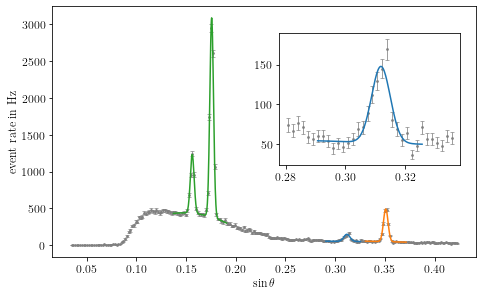

In [22]:
x = sin(LiF.index*pi/180)
y = array(LiF)
ranges = [(.29, .325), (.33, .37)]
pk, wd, params = show_fits(x, y, ranges, name='LiF', stdev=sqrt(y))
fmt = dict(fmt='.', color='gray', zorder=-1, capsize=2, elinewidth=.75, markeredgewidth=.65, markersize=4)

plt.errorbar(x, y, yerr=sqrt(y), **fmt)

lims = [.137, .19]
n0, n1 = searchsorted(x, lims) + [0, 1]
X = linspace(x[n0], x[n1-1], 250)

popt, pcov = scipy.optimize.curve_fit(N_gaussian(2, order2=True), x[n0:n1], y[n0:n1],
                                      p0 = [0.156, 1000, .003, .176, 2500, .003, 500, -500, 0])

plt.plot(X, N_gaussian(2, order2=True)(X, *popt))

_ = plt.xlabel(r'$\sin \theta$')
_ = plt.ylabel('event rate in Hz')

a = plt.axes([.54, .40, .33, .40])
n0, n1 = interval(x, .28, .335)
_ = a.errorbar(x[n0:n1], y[n0:n1], yerr=sqrt(y[n0:n1]), **fmt)

n0, n1 = interval(x, *ranges[0])
X = linspace(x[n0], x[n1-1], 150)
_ = a.plot(X, gaussian(X, *params[0]), color=PLOT_COLORS[0])

if EXPORT_FIGS:
    plt.savefig('LiF_peaks.pgf', bbox_inches='tight', transparent="True", pad_inches=0)
    
pka = array((popt[0], pk[0]))
Kb_Li = uc.ufloat(mean(pka/[1, 2]), std(pka/[1, 2], ddof=1))
/print  Kb_Li

pkb = array((popt[3], pk[1]))
Ka_Li = uc.ufloat(mean(pkb/[1, 2]), std(pkb/[1, 2], ddof=1))
/print  Ka_Li

In [23]:
# Ka = c.h * c.c / Mo_Ka * 1e12
# Kb = c.h * c.c / Mo_Kb * 1e12

print(Ka / Ka_Li, 'pm')
print(Kb / Kb_Li, 'pm')
a1 = Ka / Ka_Li
a2 = Kb / Kb_Li

w1 = 1/a1.s**2
w2 = 1/a2.s**2
a_LiF = (a1*w1 + a2*w2) / (w1 + w2) * 1e-12 + uc.ufloat(0, mean([Ka / Ka_Li**2, Kb / Kb_Li**2]).n* ang_err * 1e-12)
print(a_LiF * 1e12, 'pm') # Wikipedia: 403.51

407+/-6 pm
407+/-6 pm
407+/-6 pm


In [24]:
def rate(I, k, τ):
    R = k*I
    return R * exp(-R*τ)

<Figure size 547.2x331.2 with 0 Axes>

<ErrorbarContainer object of 3 artists>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Totzeit: 6.06+/-0.25 µs


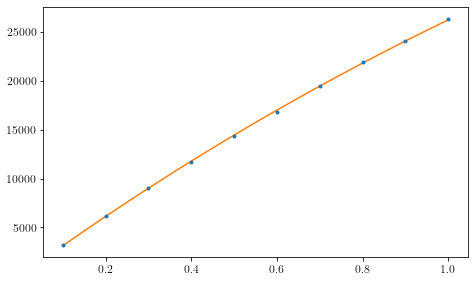

In [25]:
t = 4
figure('intensity-current')
x = array(sum(intens).index)
y = array(sum(intens))

plt.errorbar(x, y, yerr=sqrt(y) / sqrt(t), fmt='.')

popt, pcov = scipy.optimize.curve_fit(rate, x, y, sigma=sqrt(y)/sqrt(t))
k, τ = uc.correlated_values(popt, pcov)
X = linspace(min(x), max(x), 100)
plt.plot(X, rate(X, *popt))
print('Totzeit:', τ * 1e6, 'µs')
savetxt('totzeit.txt', transpose([x, y]) )

## Aufgabe 12

In [26]:
times = array([8, 8, 8, 16, 16, 16])

In [27]:
def brems(x, lmin, K):
    return K * (x / lmin - 1)/x**2 * (x > lmin)

<Figure size 547.2x331.2 with 0 Axes>

NameError: name 'first' is not defined

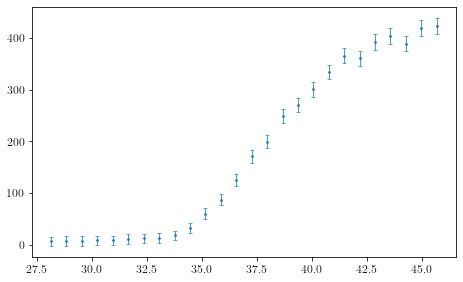

In [28]:
figure('A12')
a_LiF = 403.51e-12
fmt = dict(fmt='.', zorder=-1, capsize=2, elinewidth=.75, markeredgewidth=.65, markersize=4)

λmin = []

data_plots = []

for U, t in zip(U_lmin, times):
    x = sin(array(U_lmin[U].dropna().index) * pi/180) * a_LiF * 1e12
    y0 = array(U_lmin[U].dropna())
    y = -lambertw(-y0 * τ.n).real / τ.n
    #x = x[:21]
    #y = y[:21]
    err = sqrt(y)/sqrt(t) + mean(y[:4])
    
    data_plots.append( plt.errorbar(x, y, yerr=err, **fmt) )
    
    popt, pcov = scipy.optimize.curve_fit(brems, x, y, sigma=err)
    λmin.append(uc.ufloat(popt[0] * 1e-12, sqrt(pcov[0, 0]) * 1e-12))
    X = linspace(min(x), max(x), 200)
    if first:
        label = 'fit'
        first = False
    else:
        label = None
    fit_plot = plt.plot(X, brems(X, *popt), '-', color='black', linewidth=1, label=label)[0]
    

_ = plt.xlabel('$\lambda$ in pm')
_ = plt.ylabel('event rate in Hz')
fit
_ = plt.legend((*data_plots, fit_plot), [*(f'{U} kV' for U in U_lmin), 'fits'])

if EXPORT_FIGS:
    plt.savefig('lambda_min.pgf', bbox_inches='tight', transparent="True", pad_inches=0)
λmin = array(λmin)
print(*λmin*1e12, sep='\n')

$a = \frac{e}{h c}$ => $h = \frac{e}{a c}$

In [ ]:
figure('hbar')
x = array(list(U_lmin))* 1e3
y = unp.nominal_values(1/λmin)
yerr = unp.std_devs(1/λmin)

plt.errorbar(x, y, yerr=yerr, fmt='.')
plt.xlabel('U in V')
plt.ylabel(r'$1/\lambda$ in m$^{-1}$')

(a,), ((a_err,),) = scipy.optimize.curve_fit(direct_linear, x, y, sigma=yerr)

a = uc.ufloat(a, sqrt(a_err)) + uc.ufloat(0, mean(y) * a_LiF * ang_err * a) + uc.ufloat(0, mean(a / x) * .5e3)
a
print('error sources:')
print(f'\tstat     {c.e / c.c / a**2 *  sqrt(a_err)}')
print(f'\tsyst (θ) {c.e / c.c / a**2 *  (mean(y * a_LiF * ang_err * a))}')
print(f'\tsyst (U) {c.e / c.c / a**2 *  (mean(a / x) * .5e3)}')

plt.plot(x, x*a.n, color='red')
plt.plot(x, x*(a.n + a.s), ':', color='red')
plt.plot(x, x*(a.n - a.s), ':', color='red')
print( c.e / c.c / a )
c.h